In [33]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
tfds.disable_progress_bar()
from collections import Counter
import re
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [34]:
def removeStopeWords(text):
    counts = Counter()
    words = re.compile(r'\w+')
    counts.update(words.findall(text.lower()))

    stop_words1 = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    stop_words1.extend(nltk_words)
    sw_list = ['The',',','.']
    stop_words1.extend(sw_list)
    #text=' '.join(first100)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stop_words1]
    return " ".join(tokens_without_sw)
#print(removeStoeWords('hello of the sanja kanth'))

In [35]:
df=pd.read_excel('SourceData2022.xlsx')
print(df.shape)
df.head(10)

(4155, 3)


,ID,tweet,label
0,969,U.S. Army Corps of Engineers mobilizing to con...,Real
1,976,"The EU’s chief Brexit negotiator, Michel Barni...",Real
2,985,Work to convert the Day Patient Unit at Guerns...,Real
3,1007,US could be worse than Italy if 15-day guideli...,Unverified
4,1011,Viral message claiming that disinfection will ...,Fake
5,1016,There is an old undocumented man that “does no...,Fake
6,1020,Vitamin D supplementation reduces the risk of ...,Unverified
7,1022,"The father of Pablo Iglesias, vice-president o...",Fake
8,1036,UN is giving humanitarian aid in coronavirus e...,Fake
9,1052,WHO reported that Coronavirus lasts upto 8 hou...,Fake


In [36]:
for index, row in df.iterrows():
    df.at[index, "tweet"]=removeStopeWords(df.at[index, "tweet"])

In [37]:
df

,ID,tweet,label
0,969,US Army Corps Engineers mobilizing convert hot...,Real
1,976,EUs chief Brexit negotiator Michel Barnier tes...,Real
2,985,Work convert Day Patient Unit Guernseys Prince...,Real
3,1007,US worse Italy 15day guidelines disregarded,Unverified
4,1011,Viral message claiming disinfection conducted ...,Fake
...,...,...,...
4150,2751,Gargling salt water eliminates 2019 novel coro...,Fake
4151,2752,Former senator Antonio Trillanes IV allegedly ...,Fake
4152,2754,MOSTLY Italy decided treat elderly virus,Fake
4153,2762,matter time case UK given ease new coronavirus...,Real


In [38]:
one_hot = pd.get_dummies(df['label'])
df = df.join(one_hot)

In [39]:
df

,ID,tweet,label,Disinformative,Fake,MisInformative,Real,Unverified
0,969,US Army Corps Engineers mobilizing convert hot...,Real,0,0,0,1,0
1,976,EUs chief Brexit negotiator Michel Barnier tes...,Real,0,0,0,1,0
2,985,Work convert Day Patient Unit Guernseys Prince...,Real,0,0,0,1,0
3,1007,US worse Italy 15day guidelines disregarded,Unverified,0,0,0,0,1
4,1011,Viral message claiming disinfection conducted ...,Fake,0,1,0,0,0
...,...,...,...,...,...,...,...,...
4150,2751,Gargling salt water eliminates 2019 novel coro...,Fake,0,1,0,0,0
4151,2752,Former senator Antonio Trillanes IV allegedly ...,Fake,0,1,0,0,0
4152,2754,MOSTLY Italy decided treat elderly virus,Fake,0,1,0,0,0
4153,2762,matter time case UK given ease new coronavirus...,Real,0,0,0,1,0


In [41]:
df.drop('label', axis=1, inplace=True)
df.drop('ID', axis=1, inplace=True)
df

,tweet,Disinformative,Fake,MisInformative,Real,Unverified
0,US Army Corps Engineers mobilizing convert hot...,0,0,0,1,0
1,EUs chief Brexit negotiator Michel Barnier tes...,0,0,0,1,0
2,Work convert Day Patient Unit Guernseys Prince...,0,0,0,1,0
3,US worse Italy 15day guidelines disregarded,0,0,0,0,1
4,Viral message claiming disinfection conducted ...,0,1,0,0,0
...,...,...,...,...,...,...
4150,Gargling salt water eliminates 2019 novel coro...,0,1,0,0,0
4151,Former senator Antonio Trillanes IV allegedly ...,0,1,0,0,0
4152,MOSTLY Italy decided treat elderly virus,0,1,0,0,0
4153,matter time case UK given ease new coronavirus...,0,0,0,1,0


In [42]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9323 unique tokens.


In [43]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
y= df[['Disinformative','Fake','MisInformative','Real','Unverified']]
print(y.dtypes)
# X=df["tweet"]
# X.dtypes

Shape of data tensor: (4155, 250)


In [44]:
X.shape[1]

250

In [45]:
X

array([[   0,    0,    0, ...,  264, 4479,   89],
       [   0,    0,    0, ...,  232,  492,   57],
       [   0,    0,    0, ..., 3038,   44,  170],
       ...,
       [   0,    0,    0, ...,  175,  421,    6],
       [   0,    0,    0, ...,   42,  130,  485],
       [   0,    0,    0, ...,    2,  107,  189]])

In [46]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
epochs = 5
batch_size = 64

history = model.fit(X, y, epochs=epochs, batch_size=batch_size,validation_split=0.1)#,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
59/59 [==============================] - 66s 1s/step - loss: 0.8937 - accuracy: 0.7285 - val_loss: 0.8009 - val_accuracy: 0.6779
Epoch 2/5
59/59 [==============================] - 60s 1s/step - loss: 0.6254 - accuracy: 0.7735 - val_loss: 0.6150 - val_accuracy: 0.8149
Epoch 3/5
59/59 [==============================] - 64s 1s/step - loss: 0.3694 - accuracy: 0.8537 - val_loss: 0.6253 - val_accuracy: 0.8269
Epoch 4/5
59/59 [==============================] - 58s 982ms/step - loss: 0.2404 - accuracy: 0.9144 - val_loss: 0.7754 - val_accuracy: 0.7380
Epoch 5/5
59/59 [==============================] - 58s 990ms/step - loss: 0.1322 - accuracy: 0.9580 - val_loss: 0.7421 - val_accuracy: 0.8053


In [50]:
new_complaint = ['Vitamin C can cure covid-19']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Disinformative','Fake','MisInformative','Real','Unverified']
print(pred, labels[np.argmax(pred)])

[[2.5123073e-04 9.9844295e-01 4.3245527e-04 2.1950634e-04 6.5386127e-04]] Fake


In [51]:
new_complaint = ['The photo of a porn actor used to pass as a health professional']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Disinformative','Fake','MisInformative','Real','Unverified']
print(pred, labels[np.argmax(pred)])

[[4.7589440e-04 9.9649018e-01 6.5423158e-04 5.5853592e-04 1.8210592e-03]] Fake


In [52]:

new_complaint = ['Work to convert the Day Patient Unit at Guernsey\'s Princess Elizabeth Hospital into an Intensive Care Unit (ICU) has been completed in two weeks']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Disinformative','Fake','MisInformative','Real','Unverified']
print(pred, labels[np.argmax(pred)])

[[0.0067782  0.07793102 0.00452856 0.73384786 0.17691444]] Real


In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3739, 250) (3739, 5)
(416, 250) (416, 5)


In [54]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13/13 [==============================] - 1s 65ms/step - loss: 0.1721 - accuracy: 0.9639
Test set
  Loss: 0.172
  Accuracy: 0.964


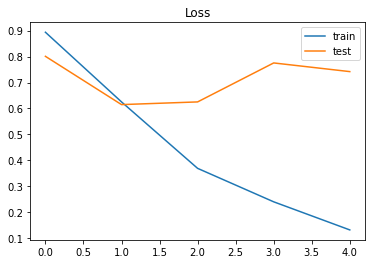

In [55]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

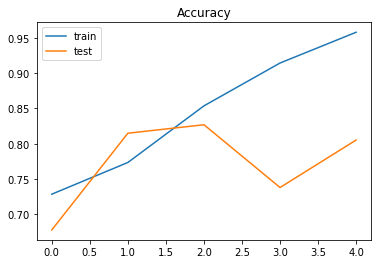

In [56]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();